In [1]:
#Desabilita logs e mantém apenas logs críticos (para evitar o libcuda ficar me avisando que a GPU tá funcionando)
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [2]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import scipy as spy
import keras
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input
from keras.optimizers import Adam,RMSprop

2021-08-16 12:01:04.142584: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
df = pd.read_csv('datasets/winequality-white.csv', sep = ',')
df.head()        

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Olhando abaixo, não temos nenhum valor N/A, então não precisamos tratar isso.

In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
print(len(df))


4898


In [6]:
df['quality'].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

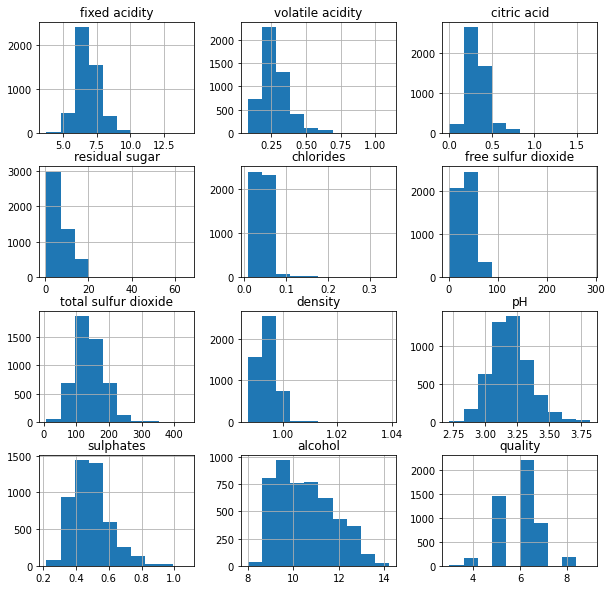

In [7]:
df.hist(figsize = (10, 10))

<h2> SMOTE </h2>

Podemos ver acima que temos um desbalanceamento na quantidade de amostras. Temos muitas regulares e poucas ruins e ótimas. Vamos usar uma técnica chamada SMOTE que consiste em fazer o oversampling das amostras minoritária}s, deixando assim o dataset balanceado. Essa técnica foi descrita no artigo.

In [8]:
X=df.drop(columns=['quality'])
y=df['quality']

In [9]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(k_neighbors=4)
X, y = oversample.fit_resample(X, y)

Vemos abaixo que as classificações agora estão igualmente distribuiídas:

In [10]:
print(y.dtypes)
print(y.count())
y.value_counts()

int64
15386


6    2198
5    2198
7    2198
8    2198
4    2198
3    2198
9    2198
Name: quality, dtype: int64

In [11]:
y[y<=4] = 0
y[((y>=5) & (y<=7))] = 1
y[y>=8] = 2    
y.value_counts()

1    6594
2    4396
0    4396
Name: quality, dtype: int64

Substituindo as faixas de qualidade por 0 (baixa), 1 (média) e 2 (alta):


In [12]:
df = pd.concat([X, y.reindex(X.index)], axis=1)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


Pronto, agora temos todas as amostras em quantias iguais.

<h2> Hot encoding </h2>

Primeiro vamos separar a qualificações que vão de 6 à 9 (no caso desse dataset) em 0 1 e 2. Sendo 0 a qualidade mais baixa, 1 a média e 2 a alta, como vamos configurar para o hot encoding posteriormente. 

No trecho de código abaixo, vou converter as varíaveis categóricas (0 1 e 2) em uma tabela. Essa tabela tem 3 colunas, onde cada uma corresponde à uma das classificações possíveis. Sempre apenas um dos items dessa coluna vai ser 1 e o resto 0. O nosso modelo ira tentar prever o valor dessas 3 colunas para assim prever a qualidade do vinho.

In [13]:
one_hot_encoded_data = pd.get_dummies(df, columns = ['quality'])
df = one_hot_encoded_data.rename(columns={'quality_0': 'baixa', 'quality_1': 'media', 'quality_2': 'alta'})
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,baixa,media,alta
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,1,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,1,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,1,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,1,0


In [14]:
y = df[['baixa','media', 'alta']]

Matriz de correlação:

<AxesSubplot:>

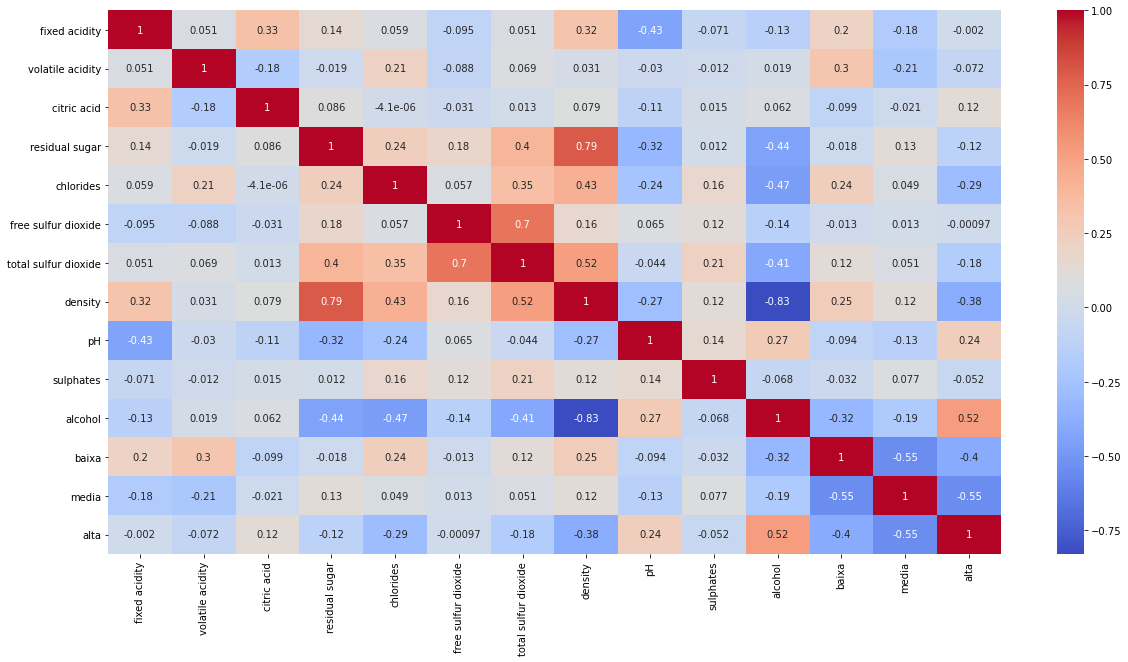

In [15]:
corr=df.corr()
plt.figure(figsize=(20,10))
sb.heatmap(corr,annot=True, cmap='coolwarm')

<h1>Separando o dataset de treinamento e o de predição</h1>

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=21)
print('Formato do dataset de treinamento Xs:{}'.format(X_train.shape))
print('Formato do datasett de teste Xs:{}'.format(X_test.shape))
print('Formato do dataset de treino y:{}'.format(y_train.shape))
print('Formato do dataset de test y:{}'.format(y_test.shape))

Formato do dataset de treinamento Xs:(12308, 11)
Formato do datasett de teste Xs:(3078, 11)
Formato do dataset de treino y:(12308, 3)
Formato do dataset de test y:(3078, 3)


<h1> Construção do modelo </h1>

O artigo utilizou relu e tanh. Aqui abaixo vamos usar relu.

In [17]:
dimension = X_train.shape[1]
from keras import backend as K
def create_model():
    model = Sequential()
    model.add(Dense(10, input_dim = dimension,  activation='relu'))
    model.add(Dense(7, input_dim = dimension,  activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 24        
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


2021-08-16 12:01:06.748883: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-16 12:01:06.775808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-16 12:01:06.776241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0c:00.0 name: NVIDIA GeForce GTX 660 Ti computeCapability: 3.0
coreClock: 1.0715GHz coreCount: 7 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 134.29GiB/s
2021-08-16 12:01:06.776265: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-16 12:01:06.778246: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-16 12:01:06.778299: I tensorflow/stream_executor/p

In [18]:
history=model.fit(X_train, y_train, validation_data=(X_test, y_test),epochs=20, batch_size=10)

Epoch 1/20


2021-08-16 12:01:06.853849: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-16 12:01:06.854130: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593305000 Hz


1231/1231 [==============================] - 1s 574us/step - loss: 1.9803 - accuracy: 0.4391 - val_loss: 0.9183 - val_accuracy: 0.5292
Epoch 2/20
1231/1231 [==============================] - 1s 507us/step - loss: 0.9240 - accuracy: 0.5139 - val_loss: 0.8722 - val_accuracy: 0.5673
Epoch 3/20
1231/1231 [==============================] - 1s 492us/step - loss: 0.8722 - accuracy: 0.5550 - val_loss: 0.8312 - val_accuracy: 0.5718
Epoch 4/20
1231/1231 [==============================] - 1s 479us/step - loss: 0.8410 - accuracy: 0.5770 - val_loss: 0.7903 - val_accuracy: 0.6153
Epoch 5/20
1231/1231 [==============================] - 1s 489us/step - loss: 0.8125 - accuracy: 0.5915 - val_loss: 0.7753 - val_accuracy: 0.6189
Epoch 6/20
1231/1231 [==============================] - 1s 492us/step - loss: 0.8073 - accuracy: 0.6075 - val_loss: 0.7658 - val_accuracy: 0.6270
Epoch 7/20
1231/1231 [==============================] - 1s 485us/step - loss: 0.7933 - accuracy: 0.6081 - val_loss: 0.8124 - val_accura

<h2>avaliação do resultado: </h2>

In [19]:
y_pred = model.predict(X_test)
def max_probs(array):
    parsed_pred = np.empty((0,3))
    for idx, x in enumerate(array):
        idx_max = x.argmax()
        x = np.zeros((3,))
        x[idx_max] = 1
        array[idx] = x

max_probs(y_pred)


In [20]:
def to_category(array):
    categories = []
    for idx, x in enumerate(array):
        idx_max = x.argmax()
        x = 0
        if idx_max == 0: x = 0
        if idx_max == 1: x = 1
        if idx_max == 2: x = 2
        categories.append(x)
    return categories


categorical_y_pred = to_category(y_pred)
categorical_y_test = to_category(y_test.to_numpy())
data = confusion_matrix(categorical_y_test, categorical_y_pred)

Matriz de confusão:

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

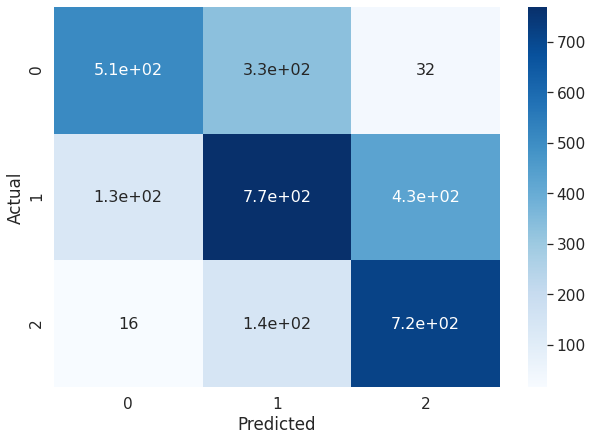

In [21]:
df_cm = pd.DataFrame(data, columns=np.unique(categorical_y_test), index = np.unique(categorical_y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sb.set(font_scale=1.4)#for label size
sb.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size